# Домашнее задание №5: "Катастрофическое забывание"

В домашней работе необходимо показать в действии проблему "катастрофического забывания".

**План для домашней работы:**
- Обучить исходную модель на датасете Food101 и проверить ее качество
- Дообучить модель на датасете STL10 с помощью Transfer Learning Fine-Tuning
- Вернуть полносвязную сеть для датасета Food101 и проверить качество модели на данном датасете
- Дообучить только полносвязный слой на Food101 и проверить удалось ли добиться исходного качества.

In [1]:
import random
import os
import inspect 

import timm
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import STL10, Food101
import torchvision.transforms as T
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm.notebook import tqdm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar
from torch import optim
import matplotlib.pyplot as plt
from IPython import display

## 1 Проверка качества исходной модели на датасете Food101

Для проведения эксперимента вначале обучим модель с нуля на датасете Food101 до устойчивых показателей обучения (cross-entropy и accuracy).

### 1.1 Создание вспомогательных классов
#### 1.1.1 Функция подсчета accuracy

In [2]:
def check_model_accuracy(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):
    """ Подсчет Accuracy Score для модели
    
    Параметры
    ---------
    model: torch.nn.Module
    dataloader : torch.utils.data.DataLoader
      Загрузчик должен быть сформирован на базе класса imagenetlib.ImageNetteDataset
      
    Результат
    ---------
    accuracy_score : float
    """
    
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    batch_accuracy_list = []
    for batch in tqdm(dataloader):
        if isinstance(batch, dict):
            image, target = batch['image'], batch['target']
        else:
            image, target = batch
        image = image.to(device)
        batch_predict = torch.argmax(model(image), axis=1)
        batch_accuracy = accuracy_score(batch_predict.cpu(), target)
        batch_accuracy_list.append(batch_accuracy)
        
    return np.mean(batch_accuracy_list)

#### 1.1.2 Класс для загрузки стандартных датасетов torchvision

In [3]:
class StandardTorchDataModule(pl.LightningDataModule):
    
    """ Загрузчик PyTorch Lighting для стандартных датасетов
    из pytorchvision
    
    !!! Тестировался не со всеми классами
    
    Параметры
    ---------
    dataset_class : pytorch Dataset
      Класс стандартного датасета из pytorchvision
    train_loader_params : dict
      Словарь для параметров DataLoader обучающего датасета.
      Имеет следующие ключи:
        - batch_size (по умолчанию 16)
        - shuffle (по умолчанию True)
        - num_workers (по умолчанию 2)
        - drop_last (по умолчанию True)
    val_loader_params : dict
      Словарь для параметров DataLoader валидационного датасета.
      Имеет следующие ключи:
        - batch_size (по умолчанию 16)
        - shuffle (по умолчанию False)
        - num_workers (по умолчанию 2)
        - drop_last (по умолчанию False)
    train_transforms : T.Compose
      Трансформации для обучающей части. По умолчанию None.
    val_transforms : T.Compose
      Трансформации для валидационной части. По умолчанию None.
    seed : int
      Фиксация генератора случайных чисел.
    """

    def __init__(self, dataset_class, name, train_loader_params=None, val_loader_params=None, 
                 train_transforms=None, val_transforms=None, seed=None):

        super().__init__()

        if seed is not None:
            set_seed(seed)
            
        self._dataset_class = dataset_class
        self._name = name

        if not train_loader_params:
            train_loader_params = {
                'batch_size': 16,
                'shuffle': True,
                'num_workers': 2,
                'drop_last': True,
            }

        if not val_loader_params:
            val_loader_params = {
                'batch_size': 16,
                'shuffle': False,
                'num_workers': 2,
                'drop_last': False
            }

        self.train_loader_params = train_loader_params
        self.val_loader_params = val_loader_params
        
        self._train_transforms = train_transforms
        self._val_transforms = val_transforms
        
    def setup(self, stage=None):
        
        dataset_params_sig = inspect.signature(self._dataset_class.__init__)
        if 'train' in dataset_params_sig.parameters.keys():
            
            train_split_params = {
                'train': True,
            }
            val_split_params = {
                'train': False,
            }
        else:
            train_split_params = {
                'split': 'train',
            }
            val_split_params = {
                'split': 'test',
            }
        
        self._train_dataset = self._dataset_class(self._name, download=True, transform=self._train_transforms,
                                                  **train_split_params)
        self._val_dataset = self._dataset_class(self._name, download=True, transform=self._val_transforms, **val_split_params)

    def train_dataloader(self):
        return DataLoader(self._train_dataset, batch_size=self.train_loader_params['batch_size'],
                          shuffle=self.train_loader_params['shuffle'], drop_last=self.train_loader_params['drop_last'],
                          num_workers=self.train_loader_params['num_workers'])

    def val_dataloader(self):
        return DataLoader(self._val_dataset, batch_size=self.val_loader_params['batch_size'],
                          drop_last=self.val_loader_params['drop_last'], shuffle=self.val_loader_params['shuffle'],
                          num_workers=self.val_loader_params['num_workers'])

#### 1.1.3 Класс HybridModel

Данный класс предназначен для удобного проведения эксперимента в рамках данной домашней работы.

Мы можем инициализировать любую модель из коллекции фреймворка timm и создать для нее два разных полносвязных слоя, которые можно менять на лету.

Пример инициализации модели:

> model = HybridModel(model_name='resnet18', fc_size_model1=101, fc_size_model2=10, pretrained=False, learning_rate=0.001)

Для проведения эксперимента реализованы следующие методы:

- set_fc_imagenet (возвращаем исходную полносвязную сеть исходной модели)
- set_fc_model1 (устанавливаем полносвязный слой для модели №1, размер выхода указывается в параметре fc_size_model1)
- set_fc_model2 (устанавливаем полносвязный слой для модели №2, размер выхода указывается в параметре fc_size_model2)
- freeze_layers (заморозка градиента от начала модели вплоть до указанного layer_name без него самого)
- unfreeze_all (разморозка градиентов всей модели)
- init_opt_parameters (можно указать какие параметры будут передаваться в оптимизатор, все или только параметры полносвязной сети)

In [4]:
class HybridModel(pl.LightningModule):
    """ Модель для обучения гибридной модели.
    
    Позволяет переключать на лету слой полносвязной сети для двух вариантов модели.
    А также позволяет заморозить определенные слои модели и определить какие параметры
    пойдут в омтимизатор.
    
    По умолчанию полносвязный слой устанавливается размером из параметра fc_size_model1
    и в оптимизатор подаются все параметры модели.
    
    
    Параметры
    ---------
    model_name : str
      Название модели (должен поддерживать фреймворк timm).
      По умолчанию resnet18
    fc_size_model1 : int
      Размер полносвязного слоя на выходе для модели 1
    fc_size_model2 : int
      Размер полносвязного слоя на выходе для модели 2
    pretrained : bool
      Если True, то будут загружены веса для предварительно обученной модели
      По умолчанию True.
    learning_rate : float
      Скорость обучения модели. По умолчанию 0.001.
    l2_regularization : float
      Размер L2-регуляризации, по умолчанию 0.01
    adam_betas : tuple
      Коэффициенты для оптимизатора Adam.
      По умолчанию (0.99, 0.999).
    plot_epoch_loss : bool
      Если True, то после каждой эпохи обучения и валидации будет выводиться график с результатами обучения
    seed : int
    """
    def __init__(self, model_name: str='resnet18', fc_size_model1: int=40, fc_size_model2: int=10, pretrained: bool =True, 
                 learning_rate: float = 0.001, l2_regularization: float = 0.01, adam_betas: (float, float) = (0.99, 0.999), 
                 plot_epoch_loss: bool = True, seed: int = None):
        
        super().__init__()
        
        if seed is not None:
            set_seed(seed)
        
        self._model = timm.create_model(model_name, pretrained=pretrained)
        
        if 'fc' in self._model.__dir__():
            self.__fc_name = 'fc'
            current_fc = self._model.fc
            fc_in_features = self._model.fc.in_features
        elif 'head' in self._model.__dir__():
            self.__fc_name = 'head'
            current_fc = self._model.head
            fc_in_features = self._model.head.in_features
        elif 'classifier' in self._model.__dir__():
            self.__fc_name = 'classifier'
            if isinstance(self._model.classifier, nn.Linear):
                current_fc = self._model.classifier
                fc_in_features = self._model.classifier.in_features
            else:
                # Обычно модели с блоком classifier содержат последовательность слоев.
                # Бывает такое, что первым слоем идет Dropout и у него нет параметра in_features
                try:
                    current_fc = self._model.classifier[0]
                    fc_in_features = self._model.classifier[0].in_features
                except:
                    current_fc = self._model.classifier[1]
                    fc_in_features = self._model.classifier[1].in_features
        else:
            raise Exception("В модели не найден блок полносвязной сети")
        
        self._fc_layers_dict = {
            'model1': nn.Linear(fc_in_features, fc_size_model1),
            'model2': nn.Linear(fc_in_features, fc_size_model2),
            'imagenet': current_fc,
        }
        
        
        # Заменяем у модели полносвязный слой на сгенерированный
        setattr(self._model, self.__fc_name, self._fc_layers_dict['model1'])
        
        # Устанавливаем тип модели, требуется для корректной смены полносвязных слоев
        self.__model_type = 'model1'
        self.__opt_params_type = 'full'
        self.init_opt_parameters(params_type=self.__opt_params_type)
        
        self.plot_epoch_loss = plot_epoch_loss
        self.learning_rate = learning_rate
        self.l2_regularization = l2_regularization
        self.adam_betas = adam_betas
        
        self.init_train_stats()

        self.save_hyperparameters()
        
    def init_train_stats(self):
        # Словарь для хранения значения ошибок на стадии обучения и валидации
        # Для значений типа train добавляем значение np.nan, так как при первом запуске модель вначале осуществляет
        # шаг валидации без обучения и добавляет значения в списки типа val. Это будет считаться эпохой №0.
        self.train_history = {
            'train_loss': [np.nan],
            'train_acc': [np.nan],
            'val_loss': [],
            'val_acc': [],
        }
        
    def init_opt_parameters(self, params_type='full'):
        """ Инициализируем параметры модели для подачи в омтимизатор
        
        Параметры
        ---------
        params_type : str
          Тип параметров для оптимизатора.
          Принимает значения full или fc.
          В случае fc в оптимизатор пойдут только параметры полносвязного слоя.
        """
        
        params_type = str(params_type).strip().lower()
        assert params_type in ('full', 'fc')
        
        if params_type == 'full':
            self._opt_parameters = self._model.parameters()
        else:
            self._opt_parameters = getattr(self._model, self.__fc_name).parameters()
            
        self.__opt_params_type = params_type
        
    def freeze_layers(self, layer_name: str):
        """ Заморозка градиента от начала модели 
        вплоть до указанного layer_name без него самого
        
        Параметры
        ---------
        layer_name : str
          Название слоя, вплоть до которого нужно выполнить заморозку
        """
        
        all_layers_names = [name for name, _ in self._model.named_modules()]
        assert layer_name in all_layers_names, "Указанный слой отсутствует в модели"
        
        for param_name, param in self._model.named_parameters():
            
            if layer_name in param_name:
                break
                
            # Не выключаем обучение параметров у всех блоков Batch Normalization
                if 'bn' in name:
                    continue
                    
            param.requires_grad = False
            
        # При изменении параметра requires_grad требуется инициализация 
        # параметров оптимизатора, так как предыдущие параметры исчезают
        self.init_opt_parameters(params_type=self.__opt_params_type)
            
    def unfreeze_all(self):
        """ Разморозка градиентов всей модели """
        
        for param_name, param in self._model.named_parameters():
            param.requires_grad = True
            
        # При изменении параметра requires_grad требуется инициализация 
        # параметров оптимизатора, так как предыдущие параметры исчезают
        self.init_opt_parameters(params_type=self.__opt_params_type)
        
    def _set_fc(self, model_type):
        """ Смена полносвязной сети на выходе модели
        
        Параметры
        ---------
        model_type : str
          Тип модели. Принимает значения model1, model2 или imagenet
        """
        
        model_type = str(model_type).strip().lower()
        assert model_type in ('model1', 'model2', 'imagenet')
        
        if not self.__fc_name == 'classifier':
            setattr(self._model, self.__fc_name, self._fc_layers_dict[model_type])
        else:
            if isinstance(self._model.classifier, nn.Linear) or isinstance(self._model.classifier[0], nn.Linear):
                setattr(self._model, self.__fc_name, self._fc_layers_dict[model_type])
            else:
                self._model.classifier[1] = self._fc_layers_dict[model_type]
            
        self.__model_type = model_type
            
    def set_fc_imagenet(self):
        """ Устанавливаем в качестве полносвязной сети слой от ImageNet
        
        Текущий полносвязный слой с его весами сохраняется и его можно вернуть
        с помощью такого же метода для другой сети
        """
        self._set_fc(model_type='imagenet')
            
    def set_fc_model1(self):
        """ Устанавливаем в качестве полносвязной сети слой от Model1
        
        Текущий полносвязный слой с его весами сохраняется и его можно вернуть
        с помощью такого же метода для другой сети
        """
        self._set_fc(model_type='model1')
        
    def set_fc_model2(self):
        """ Устанавливаем в качестве полносвязной сети слой от Model2
        
        Текущий полносвязный слой с его весами сохраняется и его можно вернуть
        с помощью такого же метода для другой сети
        """
        self._set_fc(model_type='model2')
        
    def forward(self, x_in: torch.tensor):
        forward_data = self._model(x_in)
        return forward_data

    def configure_optimizers(self):
        """Конфигурация оптимизатора и планировщика скорости обучения"""
            
        optimizer = optim.AdamW(self._opt_parameters, betas=self.adam_betas, lr=self.learning_rate,
                                weight_decay=self.l2_regularization)
        sheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                                  T_0=20,
                                                                  eta_min=1e-4)

        return [optimizer], [sheduler]

    def _share_step(self, batch: dict, batch_idx: int, mode: str = 'train'):
        """ Общий шаг для обучения, валидации и теста
        Параметры
        ---------
        batch : dict
          Батч-словарь в следующем формате:
          {
          'img': список тензоров изображения размером N x C x H x W,
          'image_path': список путей к файлам изображений,
          'target': список целевых значений,
          'parrot_name': список человекочитаемых имен попугаев,
          }
        batch_idx : int
          Номер батча
        mode : str
          Режим. Используется только для префикса названий ошибок в логе.
          По умолчанию train
        """

        # Датасет CIFAR10 генерирует кортежи
        # Датасет ImageNette генерирует словари
        if isinstance(batch, dict):
            batch_images = batch['image']
            target_true = batch['target']
        else:
            batch_images, target_true = batch
            
        target_pred = self(batch_images)

        # Считаем ошибку Binary Cross Entropy и логируем ее
        cross_entropy_loss = F.cross_entropy(target_pred, target_true)
        self.log(f'cross_entropy_{mode}_loss', cross_entropy_loss, prog_bar=True)
        
        acc_loss = accuracy_score(target_true.detach().cpu(), np.argmax(target_pred.detach().cpu(), axis=1).flatten())
        self.log(f'acc_{mode}_loss', acc_loss, prog_bar=True)

        return {'loss': cross_entropy_loss, 'acc_loss': acc_loss}

    def training_step(self, batch: dict, batch_idx: int):
        """Шаг обучения"""
        return self._share_step(batch, batch_idx, mode='train')

    def training_epoch_end(self, outputs: list):
        """Действия после окончания каждой эпохи обучения
        Параметры
        ---------
        outputs : list
          Список словарей. Каждый словарь - результат функции self._share_step для определенного батча на шаге обучения
        """

        # Считаем средние ошибки loss и acc_loss по эпохе
        avg_train_loss = torch.tensor([x['loss'] for x in outputs]).detach().mean()
        avg_acc_loss = torch.tensor([x['acc_loss'] for x in outputs]).detach().mean()

        # Добавляем средние ошибки в словарь статистики обучения, используется для построение графиков
        self.train_history['train_loss'].append(avg_train_loss.numpy().item())
        self.train_history['train_acc'].append(avg_acc_loss.numpy().item())

        # Если включено отображение графика обучения в конце эпохи, то рисуем графики
        if self.plot_epoch_loss:
            self.plot_history_loss()

    def validation_step(self, batch: dict, batch_idx: int):
        """ Шаг валидации """
        return self._share_step(batch, batch_idx, mode='val')

    def validation_epoch_end(self, outputs: list):
        """Действия после окончания каждой эпохи валидации
        Параметры
        ---------
        outputs : list
          Список словарей.
          Каждый словарь - результат функции self._share_step для определенного батча на шаге валидации
        """

        # Считаем средние ошибки loss и rmse_loss по эпохе
        avg_val_loss = torch.tensor([x['loss'] for x in outputs]).detach().mean()
        avg_acc_loss = torch.tensor([x['acc_loss'] for x in outputs]).detach().mean()
        
        # Логируем ошибку валидации
        self.log(f'val_loss', avg_val_loss, prog_bar=True)

        # Добавляем средние ошибки в словарь статистики обучения, используется для построение графиков
        self.train_history['val_loss'].append(avg_val_loss.numpy().item())
        self.train_history['val_acc'].append(avg_acc_loss.numpy().item())

        # Если включено отображение графика обучения в конце эпохи, то рисуем графики
        if self.plot_epoch_loss:
            self.plot_history_loss()

    def plot_history_loss(self, clear_output: bool = True):
        """ Функция построения графика обучения в конце эпохи
        
        Параметры
        clear_output : bool
          Если True, то после каждой эпохи график будет обновляться,
          а не печататься новый.
        """

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].plot(np.arange(0, len(self.train_history['train_loss'])),
                     self.train_history['train_loss'],
                     label="train_loss")
        axes[0].scatter(np.arange(0, len(self.train_history['train_loss'])),
                     self.train_history['train_loss'])
        axes[0].plot(np.arange(0, len(self.train_history['val_loss'])),
                     self.train_history['val_loss'],
                     label="val_loss")
        axes[0].scatter(np.arange(0, len(self.train_history['val_loss'])),
                     self.train_history['val_loss'])
        axes[0].legend(loc='best')
        axes[0].set_xlabel("epochs")
        axes[0].set_ylabel("loss")
        if len(self.train_history['val_loss'])> 1:
            val_loss_epoch_min = np.argmin(self.train_history['val_loss'][1:]) + 1
            val_loss_min = self.train_history['val_loss'][val_loss_epoch_min]
            val_loss_min = round(val_loss_min, 3) if not np.isnan(val_loss_min) else val_loss_min
            title_min_vals = f'\nValidation minimum {val_loss_min} on epoch {val_loss_epoch_min}'
        else:
            title_min_vals = ""
        axes[0].set_title('MODEL LOSS: CROSS ENTROPY'+title_min_vals)
        axes[0].grid()

        axes[1].plot(np.arange(0, len(self.train_history['train_acc'])),
                     self.train_history['train_acc'], label="train_acc")
        axes[1].scatter(np.arange(0, len(self.train_history['train_acc'])),
                     self.train_history['train_acc'])
        axes[1].plot(np.arange(0, len(self.train_history['val_acc'])),
                     self.train_history['val_acc'], label="val_acc")
        axes[1].scatter(np.arange(0, len(self.train_history['val_acc'])),
                     self.train_history['val_acc'])
        axes[1].legend(loc='best')
        axes[1].set_xlabel("epochs")
        axes[1].set_ylabel("accuracy")
        
        if len(self.train_history['val_acc'])> 1:
            val_acc_epoch_max = np.argmax(self.train_history['val_acc'][1:]) + 1
            val_acc_max = self.train_history['val_acc'][val_acc_epoch_max]
            val_acc_max = round(val_acc_max, 3) if not np.isnan(val_acc_max) else val_acc_max
            title_max_vals = f'\nValidation maximum {val_acc_max} on epoch {val_acc_epoch_max}'
        else:
            title_max_vals = ""
        axes[1].set_title('MONITORING LOSS: Accuracy'+title_max_vals)
        axes[1].grid()

        plt.show()
        if clear_output:
            display.clear_output(wait=True)

### 1.2 Обучение модели на датасете Food101

Для части датасета обучения включим случайную аугментацию, а также нормализуем с помощью средних и СКО от датасета ImageNet.

Полносвязный слой для Food101 должен иметь 101 выход, поэтому fc_size_model1 = 101. А полносвязный слой для STL10 должен иметь 10 выходов, поэтому fc_size_model2 = 10. 

В качестве модели выберем resnet18.

In [5]:
SEED = 42

train_transforms = T.Compose(
                [
                 T.Resize([96, 96]),
                 T.RandAugment(),
                 T.PILToTensor(),
                 T.ConvertImageDtype(torch.float32),
                 T.Normalize(std=(0.229, 0.224, 0.225), mean=(0.485, 0.456, 0.406)),
                ]
        )

val_transforms = T.Compose(
                [
                 T.Resize([96, 96]),
                 T.PILToTensor(),
                 T.ConvertImageDtype(torch.float32),
                 T.Normalize(std=(0.229, 0.224, 0.225), mean=(0.485, 0.456, 0.406)),
                ]
        )

config_model = {'seed': SEED,
    'model': {
        'model_name': 'resnet18',
        'fc_size_model1': 101,
        'fc_size_model2': 10,
        'plot_epoch_loss': True,
        'learning_rate': 0.0001, 
        'l2_regularization': 0.01,
        'adam_betas': (0.99, 0.999),
        'pretrained': False,
        'seed': SEED,
    },
    'trainer': {
        'max_epochs': 300,
        'gpus': 1 if torch.cuda.is_available() else 0,
        'resume_from_checkpoint': None,
    },
}

food101_config_dataset = {
    'seed': SEED,
    'dataset_class': Food101,
    'name': 'food101',
    'train_transforms': train_transforms,
    'val_transforms': val_transforms,
    'train_loader_params': {
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 0,
        'pin_memory': False,
        'drop_last': True,
    },
    'val_loader_params': {
        'batch_size': 16,
        'shuffle': False,
        'num_workers': 0,
        'pin_memory': False,
        'drop_last': False
    }
}

In [6]:
hybrid_model = HybridModel(**config_model['model'])


food101_datamodule = StandardTorchDataModule(**food101_config_dataset)

checkpoint = ModelCheckpoint(dirpath='checkpoint_first_model/', monitor='acc_val_loss', mode='max')
callbacks = [
            EarlyStopping('acc_val_loss', min_delta=0.001, patience=5, mode='max'),
            TQDMProgressBar(refresh_rate=10),
            checkpoint
]

trainer = pl.Trainer(**config_model['trainer'], callbacks=callbacks)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


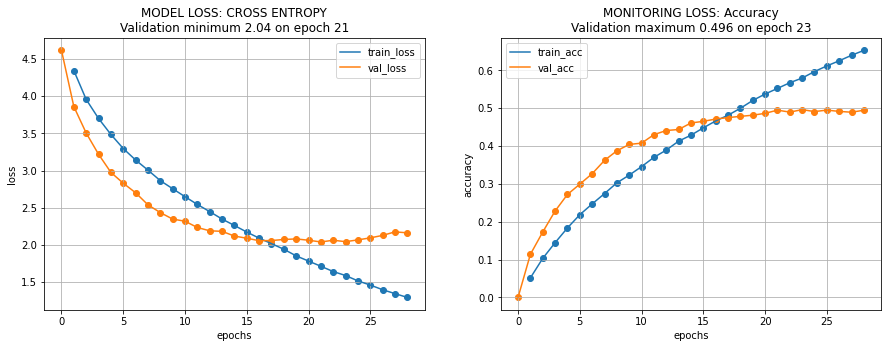

In [7]:
trainer.fit(hybrid_model, food101_datamodule)

In [8]:
# Загружаем модель с лучшим accuracy и сохраняем ее веса на диске

hybrid_model = HybridModel.load_from_checkpoint(checkpoint.best_model_path)
torch.save(hybrid_model.state_dict(), f'best_model_food101.pth')

In [9]:
model_accuracy = check_model_accuracy(hybrid_model, food101_datamodule.val_dataloader())
print('Accuracy Score', model_accuracy)

  0%|          | 0/1579 [00:00<?, ?it/s]

Accuracy Score 0.4963584547181761


В результате мы получили значение accuracy = 0.496 на валидационной части датасета.

## 2 Адаптация модели для обучения на датасете STL10 (TransferLearning и Fine-Tuning)

Что требуется сделать:

- сохранить у модели текущий полносвязный слой от модели Food101
- заменить у модели полносвязный слой на новый для датасета STL10
- заморозить градиент для 80% модели
- обучить модель с частично замороженными градиентами на датасете STL10
- разморозить все слои модели и дообучить ее на 5 эпохах на датасете STL10
- вернуть ранее обученный полносвязный слой от датасета Food101 и проверить качество модели
- дообучить только полносвязную сеть на датасете Food101 и снова проверить качество модели

### 2.1 Проведение эксперимента

#### 2.2.1 Обучение модели на датасете STL10

Возьмем модель, которую мы раньше обучили на датасете Food101 и заморозим все градиенты модели, которые предшествуют уровню с именем "layer3". Дообучим модель на датасете STL10.

In [10]:
train_transforms = T.Compose(
                [
                 T.RandAugment(),
                 T.PILToTensor(),
                 T.ConvertImageDtype(torch.float32),
                 T.Normalize(std=(0.229, 0.224, 0.225), mean=(0.485, 0.456, 0.406)),
                ]
        )

val_transforms = T.Compose(
                [
                 T.PILToTensor(),
                 T.ConvertImageDtype(torch.float32),
                 T.Normalize(std=(0.229, 0.224, 0.225), mean=(0.485, 0.456, 0.406)),
                ]
        )

stl10_config_dataset = {
    'seed': SEED,
    'dataset_class': STL10,
    'name': 'stl10',
    'train_transforms': train_transforms,
    'val_transforms': val_transforms,
    'train_loader_params': {
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 0,
        'pin_memory': False,
        'drop_last': True,
    },
    'val_loader_params': {
        'batch_size': 16,
        'shuffle': False,
        'num_workers': 0,
        'pin_memory': False,
        'drop_last': False
    }
}

In [11]:
# Устанавливаем полносвязный слой для STL10
hybrid_model.set_fc_model2()

# Замораживаем градиенты на всех слоях до layer3 не включительно
hybrid_model.freeze_layers('layer3')

# Сбрасываем статистику обучения для графика
hybrid_model.init_train_stats()

slt10_datamodule = StandardTorchDataModule(**stl10_config_dataset)

checkpoint = ModelCheckpoint(dirpath='checkpoint_second_model/', monitor='acc_val_loss', mode='max')
callbacks = [
            EarlyStopping('acc_val_loss', min_delta=0.005, patience=5, mode='max'),
            TQDMProgressBar(refresh_rate=10),
            checkpoint
]

trainer = pl.Trainer(**config_model['trainer'], callbacks=callbacks)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


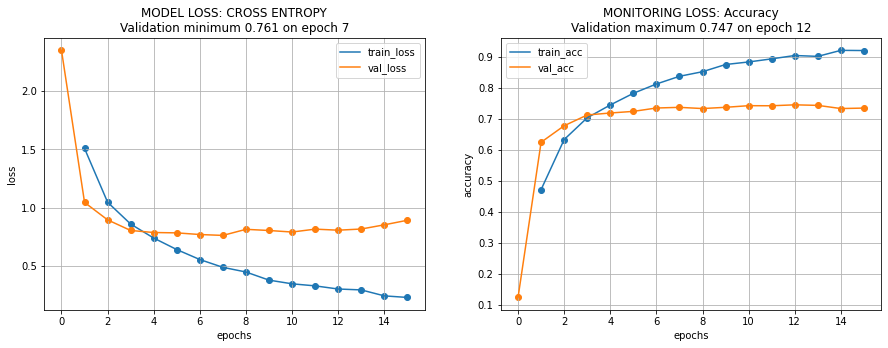

In [12]:
trainer.fit(hybrid_model, slt10_datamodule)

Наблюдаем сильное переобучение у сети. При этом веса предобученной модели помогли учиться лучше, так как без предобучения модель на первой эпохе дает результат на валидации примерно 0.2 accuracy. Модель не откатываем к наилучшим весам, так как для нашего эксперимента чем больше эпох, тем лучше проявится эффект "катастрофического забывания".

Теперь разморозим все слои модели и обучим ее на датасете STL10 в течении 5 эпох

In [13]:
config_model['trainer']['max_epochs'] = 5

hybrid_model.unfreeze_all()

slt10_datamodule = StandardTorchDataModule(**stl10_config_dataset)

callbacks = [
            TQDMProgressBar(refresh_rate=10),
]

trainer = pl.Trainer(**config_model['trainer'], callbacks=callbacks)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


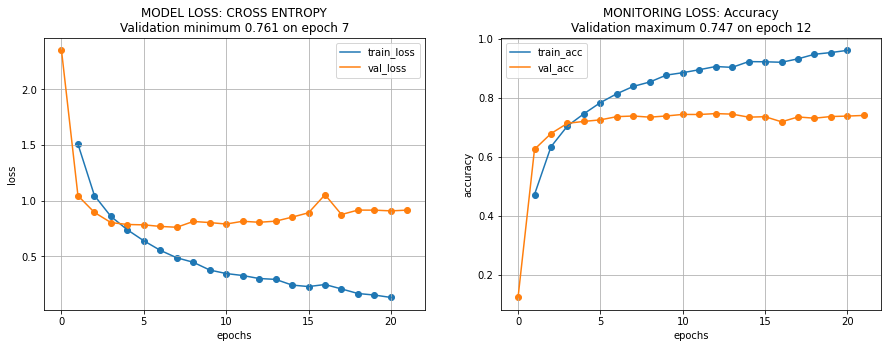

In [14]:
trainer.fit(hybrid_model, slt10_datamodule)

In [15]:
model_accuracy = check_model_accuracy(hybrid_model, slt10_datamodule.val_dataloader())
print('Accuracy Score', model_accuracy)

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy Score 0.740375


#### 2.2.2 Дообучение модели на датасете Food101

Теперь вернем для модели полносвязный слой для датасета Food101 и проверим Accuracy Score.

In [16]:
# Возвращаем полносвязный слой от Food101
hybrid_model.set_fc_model1()

# Переводим модель в режим валидации
hybrid_model.eval()

model_accuracy = check_model_accuracy(hybrid_model, food101_datamodule.val_dataloader())
print('Accuracy Score', model_accuracy)

  0%|          | 0/1579 [00:00<?, ?it/s]

Accuracy Score 0.14514724509183027


В результате модель разучилась предсказывать данные на Food101, получили значение accuracy 0.145 против 0.496 при изначальном обучении.

Чтобы это исправить и попробовать увидеть проблему "катастрофического забывания", дообучим у модели только полносвязный слой на датасете Food101.

In [17]:
config_model['trainer']['max_epochs'] = 100

# Замораживаем градиенты на всех слоях до fc не включительно
hybrid_model.freeze_layers('fc')

# В оптимизатор передаем только полносвязный слой
hybrid_model.init_opt_parameters('fc')

# Сбрасываем статистику обучения для графика
hybrid_model.init_train_stats()

callbacks = [
            EarlyStopping('acc_val_loss', min_delta=0.001, patience=5, mode='max'), 
            TQDMProgressBar(refresh_rate=10),
]

trainer = pl.Trainer(**config_model['trainer'], callbacks=callbacks)
food101_datamodule = StandardTorchDataModule(**food101_config_dataset)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


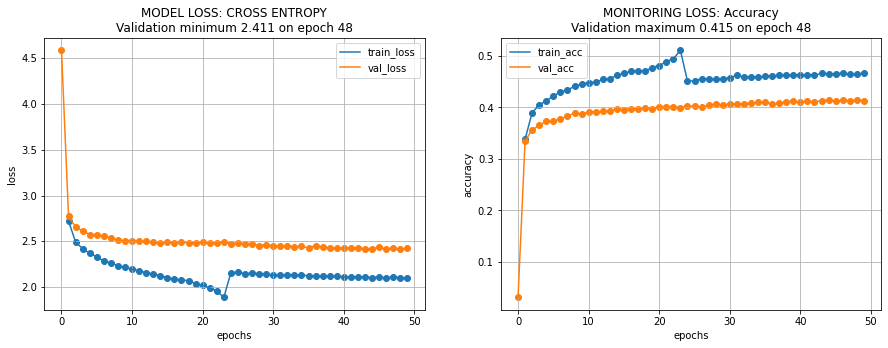

In [18]:
trainer.fit(hybrid_model, food101_datamodule)

Вернув модели полносвязный слой от Food101 и обучив только его на данном датасете нам не удалось добитться прежнего качества модели accuracy 0.496 против 0.415.

# Результаты
В домашней работе провели эксперимент и смогли показать наличие проблемы "катастрофического забывания".